<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/FFTPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FFTPCA

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
from sklearn.preprocessing import scale
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Reading in Data

### Short Cadence Data

In [4]:
# read data

data1=np.loadtxt('/content/gdrive/My Drive/BiancoGroup/phot211046195r2_ssc.2m0335.dat')
data2=np.loadtxt('/content/gdrive/My Drive/BiancoGroup/phot210327027r2_ssc.2m0355.dat')

time1,flux1,xx1,yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2,flux2,xx1,yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

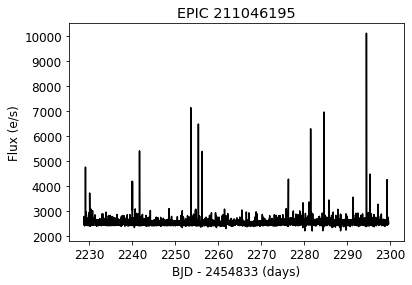

In [5]:
plt.plot(time1,flux1, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi1.png', dpi=100, bbox_inches='tight')

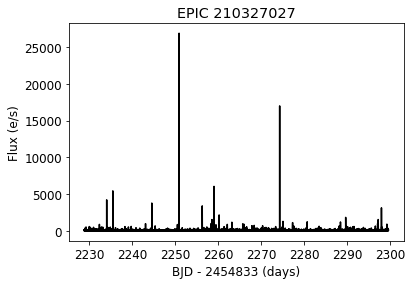

In [6]:
plt.plot(time2,flux2, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 210327027')
plt.savefig('toi2.png', dpi=100, bbox_inches='tight')

### Long Cadence Data

In [7]:
bjds = np.load('gdrive/My Drive/BiancoGroup/bjds.npy')
fluxes = np.load('gdrive/My Drive/BiancoGroup/fluxes.npy')
fluxerrs = np.load('gdrive/My Drive/BiancoGroup/fluxerrs.npy')

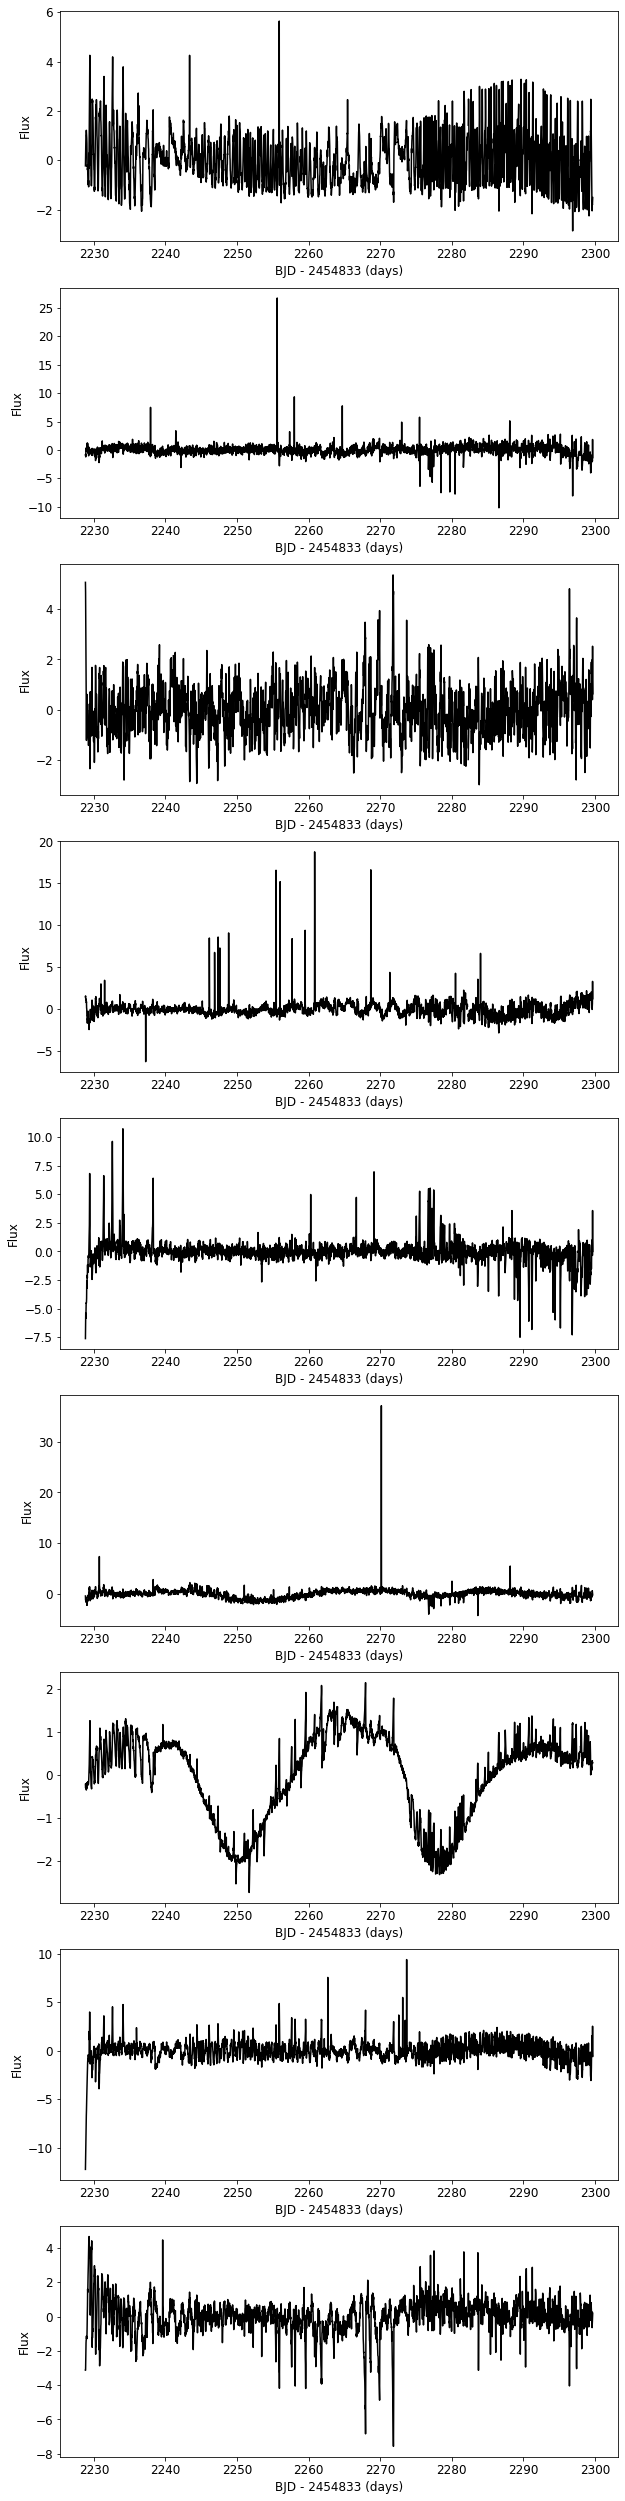

In [8]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

# FFT Filtering

In [9]:
def invgaussian(a ,m, s, x):
    g = -a * np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [10]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(1, np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [11]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

## Short Cadence FFT Filtering

In [12]:
flux1norm = flux1 / sigma_clip(flux1, sigma=3).mean()

In [13]:
flux2norm = flux2 / sigma_clip(flux2, sigma=3).mean()

In [14]:
Low_cutoff, High_cutoff, F_sample = 3.9, 4, np.diff(time1)[0]
Spectrum1, frequency1, Filtered_spectrum1, Filtered_signal1, Low_freq, High_freq = bandpass_ifft(time1, flux1norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.25, Filter='Gaussian')

In [15]:
Low_cutoff, High_cutoff, F_sample = 3.9, 4, np.diff(time2)[0]
Spectrum2, frequency2, Filtered_spectrum2, Filtered_signal2, Low_freq, High_freq = bandpass_ifft(time2, flux2norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.25, Filter='Gaussian')

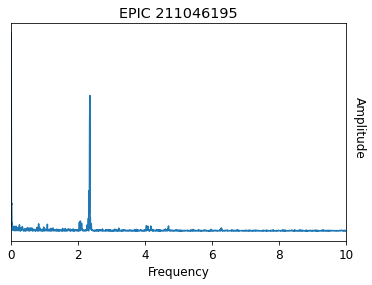

In [16]:
plt.plot(frequency1[1:],np.abs(Spectrum1[1:])**2)
plt.xlabel('Frequency')
plt.text(10.2, plt.ylim()[1]/2, 'Amplitude', rotation=-90, va='center')
plt.yticks([])
plt.title('EPIC 211046195')
plt.xlim(0,10);

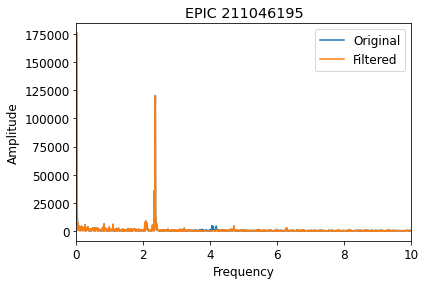

In [17]:
plt.plot(frequency1[1:],np.abs(Spectrum1[1:])**2, label='Original')
plt.plot(frequency1[1:],np.abs(Filtered_spectrum1[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend()
plt.xlim(0,10);

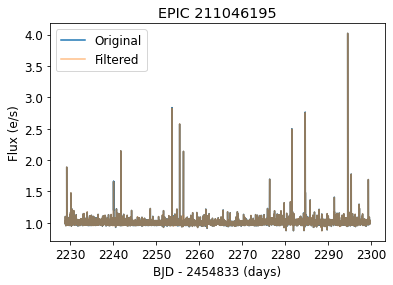

In [18]:
plt.plot(time1,flux1norm, label='Original')
plt.plot(time1,Filtered_signal1,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi1_filtered.png', dpi=100, bbox_inches='tight')
plt.legend();

In [19]:
@interact
def residplot(windowcenter = widgets.FloatSlider(min=2220, max=2310, step=0.1, value=np.median(time1)), 
              windowsize = widgets.FloatSlider(min=0.1, max=90, step=0.1, value=90)):
  
  fig = plt.figure(figsize=(10,5))

  res = flux1norm - Filtered_signal1

  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65
  #bottom_h = left_h = left + width

  rect_scatter = [left, bottom + 0.2, width, height]
  rect_histx = [left, bottom, width, 0.2]
  #    rect_histy = [left_h, bottom, 0.2, height]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter)
  axres = plt.axes(rect_histx)
  ax1.minorticks_on()
  axres.minorticks_on()
  plt.setp(ax1.get_xticklabels(),
            visible=False)

  ax1.errorbar(time1, flux1norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
  ax1.errorbar(time1, Filtered_signal1,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres.scatter(time1, res, color='k',
                               alpha=0.5, s=0.01)
  axres.set_ylabel('Residuals')

  ax1.set_xlim(windowcenter - (windowsize/2), windowcenter + (windowsize/2))
  #ax1.set_ylim(-2,2)
  axres.set_xlim(windowcenter - (windowsize/2), windowcenter + (windowsize/2))
  #axres.set_ylim(-0.5,0.5)

plt.savefig('resids.png', dpi=100, bbox_inches='tight');

interactive(children=(FloatSlider(value=2264.248628655, description='windowcenter', max=2310.0, min=2220.0), F…

<Figure size 432x288 with 0 Axes>

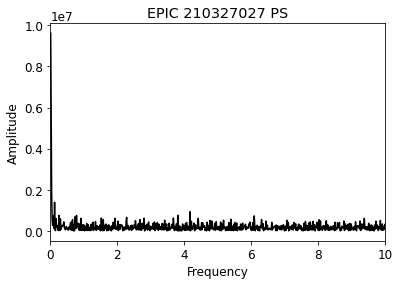

In [20]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 210327027 PS')
plt.xlim(0,10)
plt.savefig('toi2ps.png', dpi=100, bbox_inches='tight')

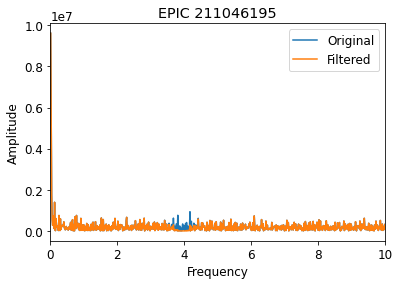

In [21]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, label='Original')
plt.plot(frequency2[1:],np.abs(Filtered_spectrum2[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend(fontsize=12)
plt.xlim(0,10);

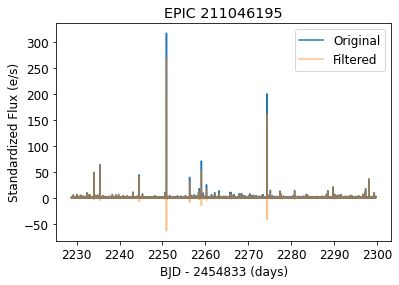

In [22]:
plt.plot(time2,flux2norm, label='Original')
plt.plot(time2[1:],Filtered_signal2,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi2_filtered.png', dpi=100, bbox_inches='tight')
plt.legend(fontsize=12);

In [23]:
@interact
def residplot(windowcenter = widgets.FloatSlider(min=2220, max=2300, step=0.1, value=np.median(time2)), 
              windowsize = widgets.FloatSlider(min=0.1, max=70, step=0.1, value=70)):

  fig = plt.figure(figsize=(10,5))

  res = flux2norm[1:] - Filtered_signal2

  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65
  #bottom_h = left_h = left + width

  rect_scatter = [left, bottom + 0.2, width, height]
  rect_histx = [left, bottom, width, 0.2]
  #    rect_histy = [left_h, bottom, 0.2, height]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter)
  axres = plt.axes(rect_histx)
  ax1.minorticks_on()
  axres.minorticks_on()
  plt.setp(ax1.get_xticklabels(),
            visible=False)

  ax1.errorbar(time2, flux2norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
  ax1.errorbar(time2[1:], Filtered_signal2,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres.errorbar(time2[1:], res, yerr=None, color='k',
                               alpha=0.1, fmt='.')

  axres.ticklabel_format(axis="y", style="sci")
  axres.set_xlabel('BJD - 2454833 (days)')
  axres.set_ylabel('Residuals')

  ax1.set_xlim(windowcenter - (windowsize/2), windowcenter + (windowsize/2))
  #ax1.set_ylim(-2,2)
  axres.set_xlim(windowcenter - (windowsize/2), windowcenter + (windowsize/2))
  #axres.set_ylim(-0.5,0.5)

interactive(children=(FloatSlider(value=2264.24304222, description='windowcenter', max=2300.0, min=2220.0), Fl…

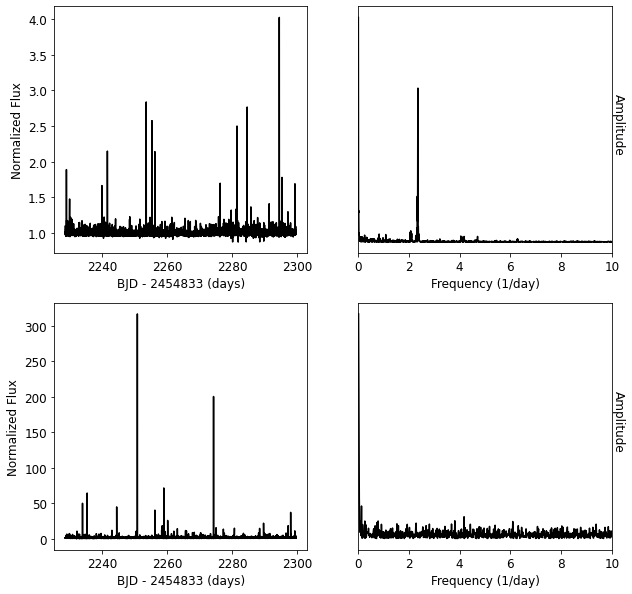

In [24]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(time1,flux1norm, c='k')
ax[1,0].plot(time2,flux2norm, c='k')
ax[0,1].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')
ax[1,1].plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')

ax[0,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[0,1].set_xlabel('Frequency (1/day)', fontsize = 12)
ax[1,0].set_xlabel('BJD - 2454833 (days)', fontsize = 12)
ax[1,1].set_xlabel('Frequency (1/day)', fontsize = 12)

ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[1,0].set_ylabel('Normalized Flux', fontsize = 12)

ax[0,1].text(10, ax[0,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)
ax[1,1].text(10, ax[1,1].set_ylim()[1]/2, 'Amplitude', va='center', fontsize = 12, rotation=-90)

ax[0,1].set_xlim(0,10)
ax[1,1].set_xlim(0,10)

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

plt.savefig('4plot.png', dpi=100, bbox_inches='tight')

# PCA with Spectra

In [25]:
from sklearn.decomposition import PCA

In [26]:
pspec_dict = {}


for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [27]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,spec11,spec12,spec13,spec14,spec15,spec16,spec17,spec18,spec19,spec20,spec21,spec22,spec23,spec24,spec25,spec26,spec27,spec28,spec29,spec30,spec31,spec32,spec33,spec34,spec35,spec36,spec37,spec38,spec39,...,spec960,spec961,spec962,spec963,spec964,spec965,spec966,spec967,spec968,spec969,spec970,spec971,spec972,spec973,spec974,spec975,spec976,spec977,spec978,spec979,spec980,spec981,spec982,spec983,spec984,spec985,spec986,spec987,spec988,spec989,spec990,spec991,spec992,spec993,spec994,spec995,spec996,spec997,spec998,spec999
0,2444.330836,3491.401379,17691.849961,24.533747,6.163901e+03,631.853491,276.295785,15020.322357,195.025521,22788.457538,122.644158,744.483324,486.480440,4829.527775,115.343956,1.125124e+03,71.371679,55.547027,154.868007,459.894745,7200.959461,1.804208e+02,5.698959e+02,604.862044,3290.135077,126.469392,1360.142167,286.291479,854.928738,2282.735311,53.553424,183.552048,3963.907229,217.826750,423.021154,48.645497,11.089274,694.939166,316.937049,6341.464955,...,7.053689e+02,5741.398547,1974.034778,12.883895,244.876068,17.945155,147.320248,473.718687,3086.965587,18.517510,39.886534,36912.545157,171.728084,205.366165,9083.149050,1189.289443,396.300148,3796.981571,194.792739,3170.655928,6903.165039,20458.005481,506.779400,38.529912,75.189619,29.928129,521.970928,1587.945565,227.675684,10383.472846,33.260864,8.329918e+01,429.686300,3.495277e+02,10.796121,604.412834,74.000805,15.231185,1578.632726,0.325671
1,188558.097947,24932.464107,27502.736287,11596.062242,1.329584e+06,21881.098032,7824.408002,1708.935209,33900.530576,106001.638933,1714.695216,5970.429323,5195.674056,3903.657055,205960.239018,1.487098e+05,6509.497032,7284.581972,7118.518049,111288.498777,55386.301937,1.637470e+06,4.049837e+04,260991.535074,4009.656855,100452.383594,126842.902640,10912.431634,311380.189166,88330.124764,266165.813364,73.303031,1545.337177,14445.835462,13865.990576,51685.446538,76.906537,6402.826163,11332.499145,469711.453297,...,2.146108e+06,67549.574910,37997.895336,214.166674,7106.450057,949.311945,2787.012911,2050.259510,577881.862653,104643.565355,6801.314075,843756.539828,10712.952178,33186.728891,492457.160590,159865.667513,157433.954642,2569.793900,25435.795582,12465.524090,188717.271374,13592.901921,112504.554268,4099.568462,21967.427993,392940.300516,50689.522379,198956.279680,224234.513212,150894.704762,39012.940662,2.852149e+04,221522.421770,2.701112e+05,16677.137662,78130.343520,54050.845570,7015.700238,701.526990,33601.833088
2,137018.884662,40621.698347,26031.074624,99011.951142,1.027931e+05,60128.856707,74299.255923,12094.348022,523997.575650,84198.566845,4572.978071,28711.529051,5097.875052,65427.268324,661204.907387,1.087525e+06,73626.514343,148899.120651,1160.562522,294465.281906,13354.839379,8.205087e+04,2.009052e+06,912668.261980,8205.490558,455298.814130,105245.377776,15907.563584,14302.787773,20275.488096,866174.099999,31670.219480,25438.704259,54754.592069,159545.857930,77691.954789,22015.960499,72277.990145,60089.796976,371161.825318,...,3.005605e+05,389917.640201,16912.129871,55577.880236,32981.263191,685.563050,39814.067023,3467.248627,607382.721694,3213.775223,2228.358424,659363.017250,22375.991447,2578.673133,283399.914685,28065.623084,239237.948305,24714.922095,88019.300111,127579.238185,182433.537766,20569.918923,350616.556027,142993.682024,21844.023666,304050.403424,54862.457459,416133.892651,75457.724270,334922.497540,1388.401516,7.674183e+04,411180.284071,1.482621e+05,86068.824882,164012.481497,86414.240316,6035.216574,83485.735451,23158.742652
3,8088.677230,1279.610214,25525.877039,7997.888711,1.717962e+05,15107.184941,41440.697136,7385.217256,68834.422406,119432.561355,10090.082430,22815.623511,28130.017529,40254.817795,105184.931727,4.753867e+02,13289.207640,45004.367288,38007.771681,176072.399569,40703.417137,5.357253e+04,8.393091e+05,183839.541245,6795.807897,7152.384732,66033.927497,185.714355,499855.388857,94612.030396,111710.

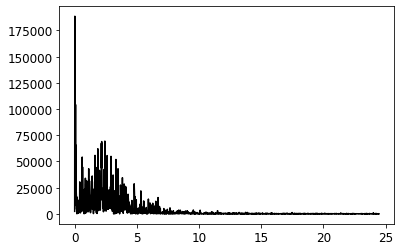

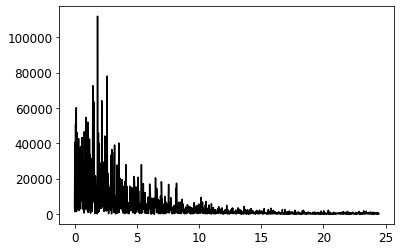

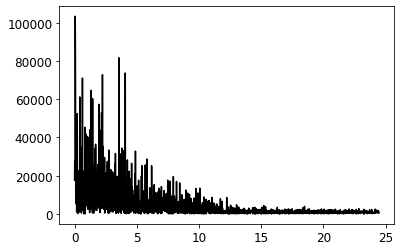

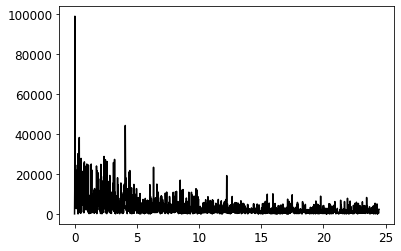

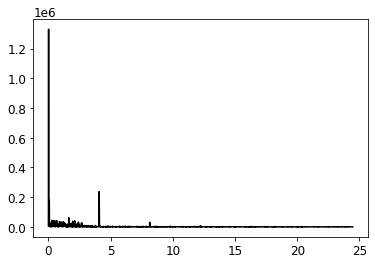

In [28]:
for i in range(5):
  plt.plot(frequency, pspec_df.values[:,i], c='k')
  plt.show()

In [29]:
'''
### Remove first values from PS:
pspec_df = pspec_df.drop([0,1,2,3,4])
pspec_df.head()
'''

'\n### Remove first values from PS:\npspec_df = pspec_df.drop([0,1,2,3,4])\npspec_df.head()\n'

In [30]:
pspec_df.shape

(1735, 1000)

In [31]:
x = pspec_df.values
x = scale(x, axis=0)

In [32]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,-0.976851,5.335109,-0.635924,0.426727,-0.149198,0.594171,1.446605,0.675921,0.419251,-0.170973,0.489478,0.019826,0.845712,-0.025173,1.229741,-0.702027,0.509350,4.456346,1.394070,-0.128602,0.899398,0.099460,0.881552,1.736740,0.360861,0.605632,1.615365,0.967534,-0.895324,-1.186730,-1.241402,0.579152,-0.966251,0.297330,-0.231618,0.399253,0.883389,-0.007520,0.086558,-0.496454,...,-8.633295e-05,-3.306221e-05,-1.027651e-04,7.164829e-05,-2.508115e-04,-1.274743e-04,2.011344e-05,5.186703e-05,7.607517e-07,3.449881e-06,9.557003e-06,3.940404e-05,9.500646e-05,-4.145949e-05,5.453783e-05,-2.428012e-06,9.162121e-05,-3.606251e-05,-3.788499e-05,1.399855e-04,2.569408e-05,3.098328e-05,-4.271006e-06,5.515134e-05,2.593796e-05,1.723012e-04,3.954402e-06,-4.239946e-06,6.235083e-05,1.473911e-04,9.705129e-05,-1.991950e-05,1.209915e-05,1.607438e-05,-1.457954e-05,-5.352218e-06,-2.024611e-05,-1.570068e-05,-1.613461e-06,-2.141829e-07
1,204.148185,295.006662,-6.975532,40.328249,32.018923,-11.744238,-18.781720,-3.156247,-2.028993,1.815808,-1.930969,1.630419,-1.484843,0.421049,-2.358499,2.737002,-0.789714,-12.737896,-2.917544,1.769271,-3.908805,-0.966570,-0.770100,-3.142863,1.000340,-0.047711,-2.326815,-0.252189,0.133086,1.499012,0.488023,-1.434580,1.667625,-1.806185,0.271647,-1.649757,-0.974006,-0.932304,0.161687,-0.103077,...,5.068940e-08,3.503007e-08,-1.034998e-07,-5.273934e-08,2.472118e-08,6.801111e-09,6.192013e-08,1.629354e-08,7.994749e-08,8.467880e-08,4.711832e-08,-6.123836e-08,1.190618e-07,-5.839108e-08,-5.683294e-08,-9.653291e-08,-4.481275e-08,8.687193e-08,4.281000e-08,-8.837284e-08,1.696485e-08,8.167234e-08,-7.145102e-09,-4.399348e-08,-5.085166e-09,-3.091639e-08,5.701790e-10,2.133623e-08,-3.207290e-08,-8.294473e-08,-7.305527e-08,1.089953e-08,-7.434681e-09,-1.106567e-08,2.230697e-08,5.975942e-09,2.087342e-08,1.388444e-08,2.734884e-09,-6.735889e-10
2,372.084336,-27.892496,241.148784,-66.463167,-26.688698,-5.604747,-7.383737,1.605789,-2.771667,-1.688595,-1.477271,-0.196043,-1.757387,0.043508,-0.884610,0.808677,-0.760968,0.569646,-0.999200,0.761920,0.636406,0.916087,-1.717314,0.153342,-1.219451,0.112188,-0.313849,0.187303,-0.597867,0.987147,0.764877,-0.368211,0.717962,-0.594648,0.547503,-0.704478,0.667457,-0.467900,-0.904811,-0.205926,...,-3.637574e-08,-3.050873e-08,2.922564e-07,3.100499e-07,5.304582e-08,1.268890e-07,6.820309e-08,-2.104927e-07,-1.319437e-08,6.733425e-08,3.050249e-08,1.522877e-07,-2.541254e-07,2.254687e-07,-8.097117e-08,1.027922e-07,1.686811e-07,-6.944150e-08,6.753835e-08,1.618742e-07,-1.445596e-07,-1.500680e-08,-1.763894e-08,-6.642797e-08,2.059282e-07,-2.382255e-07,-4.784258e-08,6.591290e-08,-1.709230e-08,-2.108607e-08,3.325795e-08,-3.521617e-08,6.196569e-08,-4.798948e-08,1.852050e-08,-2.399048e-08,-1.306439e-08,-1.052073e-08,-1.940447e-08,2.089708e-08
3,267.782555,-62.642841,-25.544949,204.578245,-105.998911,-2.221424,-18.307529,2.020841,-3.571498,1.620010,-0.244569,-1.777545,-0.841440,0.693821,-0.036713,0.802497,0.965747,-2.603827,-0.956463,0.345151,-1.479030,0.942936,-1.468743,-0.078501,-0.561107,0.456978,-0.519926,-0.612897,0.008332,-0.976370,-0.592196,-0.343997,-1.069822,0.414242,-1.039104,-0.111979,0.029879,-0.511181,-0.346648,-0.089471,...,-1.987596e-07,-3.688879e-07,-2.827400e-07,-3.646514e-07,1.075803e-07,-2.435946e-07,-3.998125e-07,-8.305422e-08,1.253341e-07,-6.538196e-07,-6.942112e-08,-1.544667e-07,2.608349e-07,1.568146e-07,-8.287001e-08,-4.465702e-08,-2.497056e-07,8.481776e-08,2.654555e-07,5.884127e-08,5.118542e-07,1.672667e-07,1.152073e-07,-2.710796e-07,-1.651153e-07,-9.136843e-09,4.643394e-08,1.128100e-07,-2.096698e-07,-8.928886e-08,-8.086415e-08,-9.126744e-08,3.000561e-08,6.304849e-08,-1.127477e-08,-1.099858e-10,-2.337176e-08,-2.024111e-08,2.418073e-08,

In [33]:
pca_df.to_csv("/content/gdrive/My Drive/BiancoGroup/pcaLongTermCadenceK2.csv")

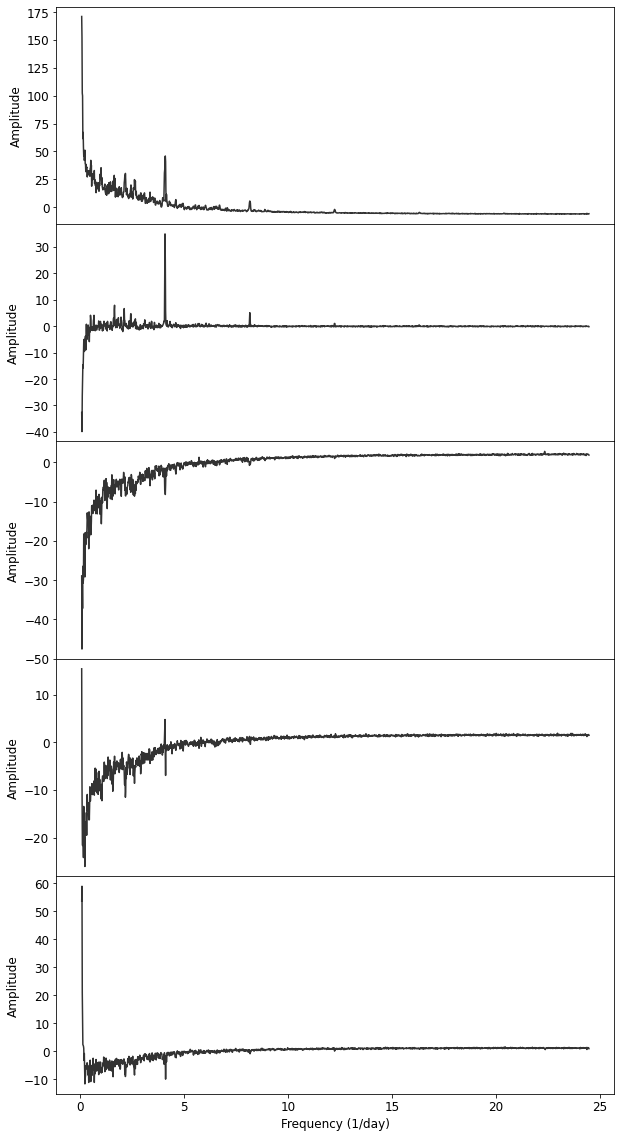

In [34]:
fig, axes = plt.subplots(5, figsize=(10,20), sharex=True)
p = 0
for i in range(5):
  axes[p].plot(frequency[5:],pca_df[i][5:], c='k', alpha=0.8)
  axes[p].set_ylabel('Amplitude')
  p += 1
plt.xlabel('Frequency (1/day)')
plt.subplots_adjust(hspace=0)
plt.savefig('pspcs.png', dpi=100, bbox_inches='tight')

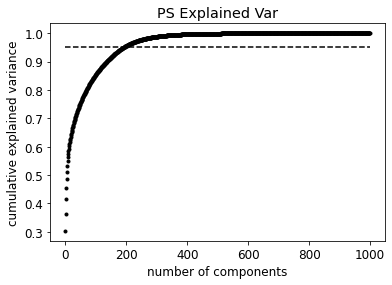

In [35]:
a = np.arange(0,len(x[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x[0]),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PS Explained Var')
plt.savefig('expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

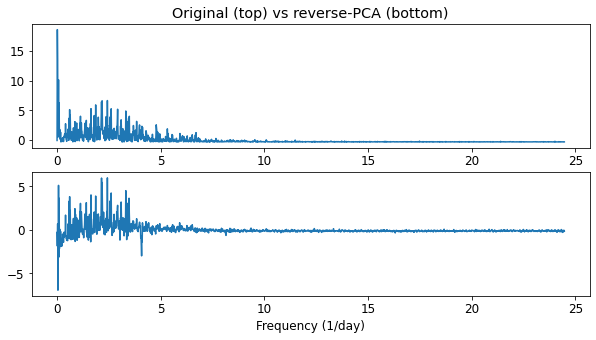

In [36]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency, Xhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca_compare.png', dpi=100, bbox_inches='tight')

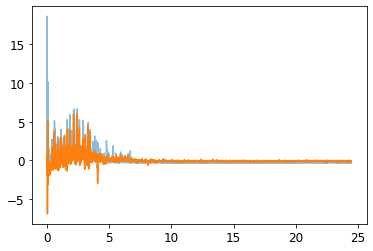

In [37]:
plt.plot(frequency,x[:,0], alpha=0.5)
plt.plot(frequency, Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

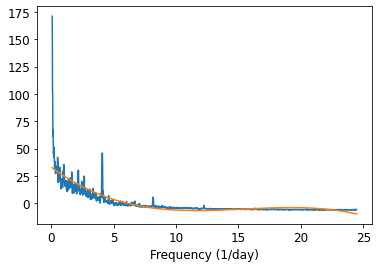

In [38]:
a, b, c, d = np.polyfit(frequency[5:], pca_df[0][5:], deg=3)

fit = a * frequency[5:]**3 + b * frequency[5:]**2 + c * frequency[5:] + d

plt.plot(frequency[5:], pca_df[0][5:])
plt.plot(frequency[5:], fit)
plt.xlabel('Frequency (1/day)')
plt.savefig('PC1_fit.png', dpi=100, bbox_inches='tight')

In [39]:
def gaussian(a, m, s, x):
    g = a * np.exp(-(m-x)**2 / s**2) 
    return g

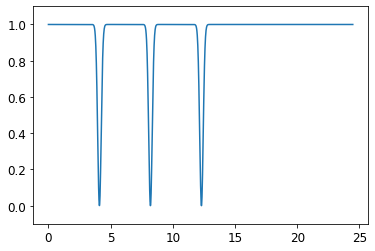

In [40]:
def hrm_gfilter(x, s, fund, nhrm=0, amps=np.ones(len(x))):

  fhrms = np.array([fund])

  for i in range(2, nhrm+2):
    fhrms = np.append(fhrms, i*fund)

  filt = np.ones(len(x))

  for hrm, amp in zip(fhrms, amps):
    filt *= invgaussian(amp,hrm,s,x) 
   # filt += gaussian(amp,hrm,s,x)

  return filt

filt = hrm_gfilter(frequency, 0.2, 4.1, 2)

plt.plot(frequency, filt)
plt.ylim(-0.1,1.1);

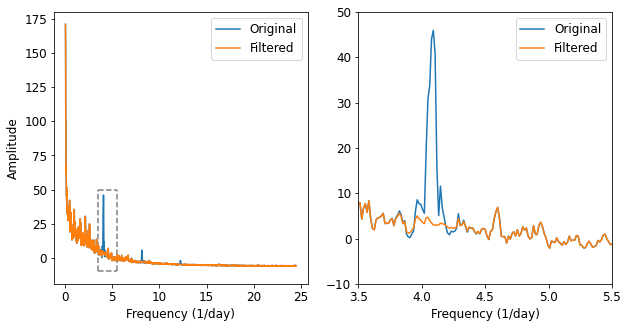

In [41]:
###Bandpass filtering:

#Some params:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)

pc1 = np.copy(pca_df[0])#to avoid overwriting

#Make array of fund & harmonic indices:
hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


#For each index, calculate local avg, subtract, filter, add avg back:
for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc1[5:] -= local_avg
  pc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc1[5:] += local_avg

#Plotting:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[0].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', ls='--')
ax[0].vlines(5.5,-10,50, color='grey', ls='--')
ax[0].hlines(50,3.5,5.5, color='grey', ls='--')
ax[0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[1].plot(frequency[5:], pca_df[0][5:], label='Original')
ax[1].plot(frequency[5:], pc1[5:], label='Filtered')
ax[0].set_xlabel('Frequency (1/day)')
ax[1].set_xlabel('Frequency (1/day)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend()
plt.savefig('pc1filter.png', dpi=100, bbox_inches='tight');

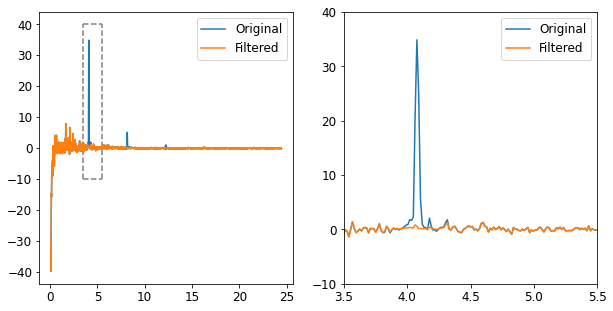

In [42]:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.2
pts_per_std = int(std/fstep)
pc2 = np.copy(pca_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((pc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       pc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  pc2[5:] -= local_avg
  pc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  pc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[0].plot(frequency[5:], pc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,40, color='grey', ls='--')
ax[0].vlines(5.5,-10,40, color='grey', ls='--')
ax[0].hlines(40,3.5,5.5, color='grey', ls='--')
ax[0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[1].plot(frequency[5:], pca_df[1][5:], label='Original')
ax[1].plot(frequency[5:], pc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,40)
ax[0].legend()
ax[1].legend();

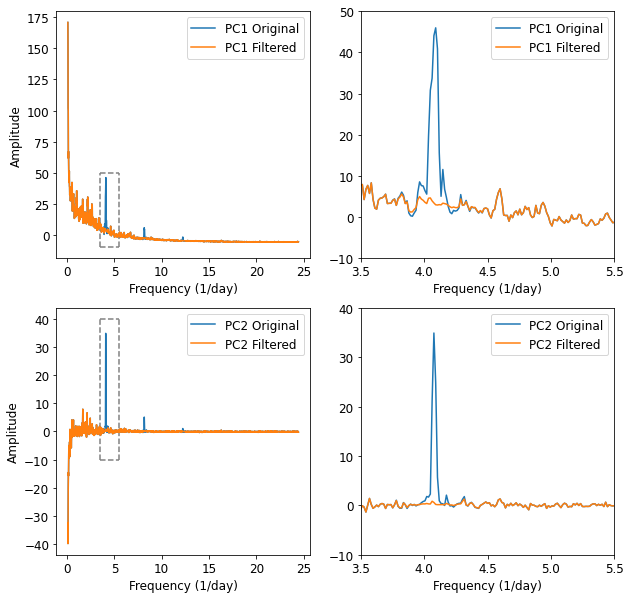

In [43]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(frequency[5:], pca_df[0][5:], label='PC1 Original')
ax[0,0].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,0].vlines(3.5,-10,50, color='grey', ls='--')
ax[0,0].vlines(5.5,-10,50, color='grey', ls='--')
ax[0,0].hlines(50,3.5,5.5, color='grey', ls='--')
ax[0,0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[0,1].plot(frequency[5:], pca_df[0][5:], label='PC1 Original')
ax[0,1].plot(frequency[5:], pc1[5:], label='PC1 Filtered')
ax[0,0].set_xlabel('Frequency (1/day)')
ax[0,1].set_xlabel('Frequency (1/day)')
ax[0,0].set_ylabel('Amplitude')
ax[0,1].set_xlim(3.5,5.5)
ax[0,1].set_ylim(-10,50)
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(frequency[5:], pca_df[1][5:], label='PC2 Original')
ax[1,0].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,0].vlines(3.5,-10,40, color='grey', ls='--')
ax[1,0].vlines(5.5,-10,40, color='grey', ls='--')
ax[1,0].hlines(40,3.5,5.5, color='grey', ls='--')
ax[1,0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[1,1].plot(frequency[5:], pca_df[1][5:], label='PC2 Original')
ax[1,1].plot(frequency[5:], pc2[5:], label='PC2 Filtered')
ax[1,0].set_xlabel('Frequency (1/day)')
ax[1,1].set_xlabel('Frequency (1/day)')
ax[1,0].set_ylabel('Amplitude')
ax[1,1].set_xlim(3.5,5.5)
ax[1,1].set_ylim(-10,40)
ax[1,0].legend()
ax[1,1].legend()
plt.savefig('pcfilter.png', dpi=100, bbox_inches='tight');

In [44]:
t = np.array([pc1,pc2])
filtered_transform = pca.transform(x).copy()
print(t.T.shape, filtered_transform[:,0:2].shape)
filtered_transform[:,0:2] = t.T

(1735, 2) (1735, 2)


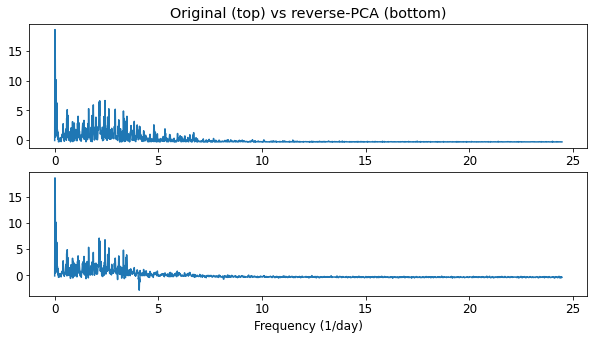

In [45]:
Xhat1 = np.dot(filtered_transform[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency,Xhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

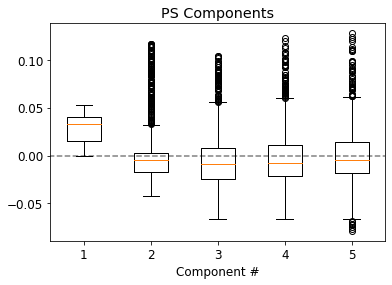

In [46]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.hlines(0, 0, 7, linestyle='--', alpha=0.5)
plt.xlabel('Component #')
plt.title('PS Components')
plt.xlim(0.5,5.5)
plt.savefig('box.png', dpi=100, bbox_inches='tight')
plt.show()

# PCA with DFTs

In [47]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [48]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [49]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

2.047673590086744e-18 8.190694360346977e-18


In [50]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [51]:
pca.fit(y.real)

Y = pca.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)
pca2_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,-1.838565,2.285646,17.770349,7.106233,7.368178,-10.637668,-2.626060,-2.243572,-13.846381,10.848089,1.315228,-0.969646,-4.073646,2.850896,5.488577,3.089539,2.677268,1.699955,2.723134,-0.758991,-7.448331,0.684649,4.619498,1.998696,-2.221349,1.014998,-3.305636,-3.341825,-1.281029,-2.799936,0.434698,1.444657,-4.433268,-0.348009,0.233129,0.427897,1.744933,-1.698010,-0.399343,0.021250,...,0.077979,0.011271,0.077716,0.067639,-0.059798,-0.134233,-0.016645,-0.045650,-0.010701,0.035649,0.099002,0.041570,0.036870,-0.016412,0.051885,0.079543,-0.010387,-0.027285,0.003300,-0.032676,0.028191,0.017208,0.080991,-0.034765,0.074579,0.033398,0.019480,0.089315,-0.047063,-0.015178,3.665082e-02,0.026613,0.056668,-0.004807,-0.012413,-0.025359,-0.045385,0.008117,0.003833,0.028619
1,18.577521,29.401864,143.302229,20.052352,31.617942,26.081528,-16.774692,-4.773384,38.976983,-45.345747,15.639597,21.872197,14.091974,36.459717,-32.558994,-30.164096,-0.782260,-16.790426,-9.483739,-3.909996,-20.563930,-16.760561,27.727537,9.105270,-13.539751,-1.569979,-2.194018,-18.203354,13.775753,0.736119,12.037921,10.580112,-2.980041,-3.960164,-5.191727,10.146385,-1.618297,-12.573240,-0.172916,-0.610997,...,0.006482,0.000957,0.002073,0.003310,0.000827,0.005151,-0.001597,0.002182,0.003555,-0.006180,-0.003062,0.000412,0.004037,-0.001740,0.003561,0.000049,0.000935,-0.001299,0.001537,0.001611,-0.002362,0.002224,-0.000668,0.001287,-0.001314,0.000703,0.003529,0.000011,-0.000321,-0.000566,4.750012e-05,0.000192,-0.000582,-0.000193,0.000861,0.000640,-0.001154,0.000289,-0.000127,-0.000984
2,175.629309,36.813442,12.354204,-88.785564,-15.707373,-37.154931,51.012836,-23.853110,62.522721,4.631871,-5.794060,58.715373,-28.826088,-3.695397,7.477388,9.436590,2.886468,3.334990,15.381342,-1.115152,1.534434,-0.513820,-14.579554,-7.670554,0.470828,5.649104,-0.530369,-2.993388,-10.227200,-3.321380,-0.464888,0.326974,-1.248534,0.225605,-0.606250,0.325711,-0.258504,-0.179586,0.497019,-0.606487,...,0.003838,0.002705,0.002906,0.003760,-0.005844,-0.003994,0.002695,-0.003042,-0.001836,-0.000193,0.002841,0.003487,0.001808,-0.001747,0.004223,0.001653,-0.001709,-0.002138,0.002357,0.002442,-0.001699,0.000876,0.000158,-0.001029,0.001793,0.000717,-0.000070,0.002739,-0.000740,-0.000685,-1.135453e-04,0.000581,-0.000772,0.000636,0.000594,0.000290,-0.000981,-0.000113,0.001074,0.000230
3,52.153110,-16.656579,9.996336,163.211009,15.689811,46.077616,108.011457,2.973764,-1.259390,-8.589616,-30.936004,2.942781,-3.972216,-9.414259,7.877772,16.711484,2.266741,8.098264,-2.084995,-12.918576,3.757250,-13.797706,-1.854545,-11.026457,1.547071,0.408415,3.017272,-5.132654,-2.218584,1.810699,-5.816985,-2.099400,-1.872624,0.269975,3.882648,4.285183,-0.489612,-2.485329,2.039062,-1.928877,...,0.000393,0.001007,0.000837,-0.001763,0.007848,0.006148,-0.002307,-0.003075,0.005904,-0.004473,-0.000070,0.003344,0.004109,-0.008059,0.000920,0.003454,-0.000885,-0.002560,0.000616,-0.002481,0.001760,-0.000166,0.001311,0.000596,-0.002121,-0.002293,0.004056,-0.001018,-0.000461,0.000955,6.657923e-04,-0.001742,0.001075,-0.000168,0.002913,-0.002163,0.000483,0.000001,-0.001501,0.000898
4,59.415372,54.288482,21.757535,56.411003,-17.068195,-9.492869,-43.337563,56.584369,78.417990,66.569370,50.875604,-51.616102,8.132829,-11.380774,-11.121566,37.458887,3.908974,3.589850,-5.084801,-1.402471,7.892929,-1.671801,2.770281,-1.256099,3.933067,6.633203,-0.260641,-0.678695,2.366151,-0.476468,-1.195845,-4.282647,0.163017,-2.004342,0.705076,4.658076,0.241850,-4.060250,1.404968,0.492474,...,-0.002352,-0.005877,0.005367,0.004747,0.001212,0.002901,-0.006677,-0.002499,0.000313,-0.000561,0.004858,-0.001949,-0.003424,-0.003007,-0.001484,-0.000744,0.000237,0.000097,0.002063,0.000635,0.001908,0.00

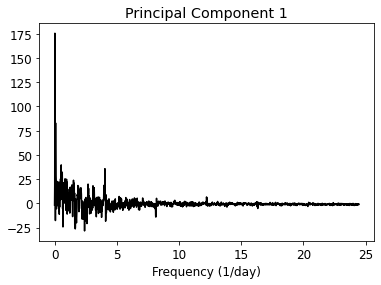

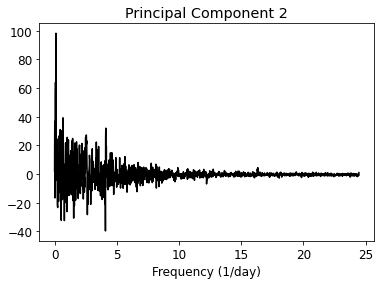

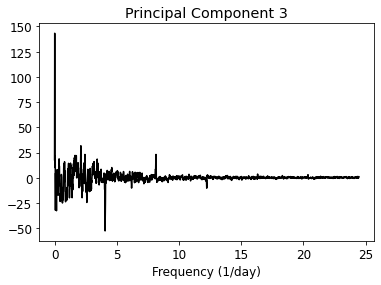

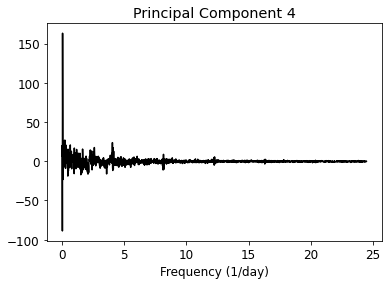

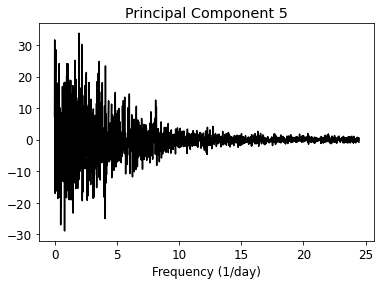

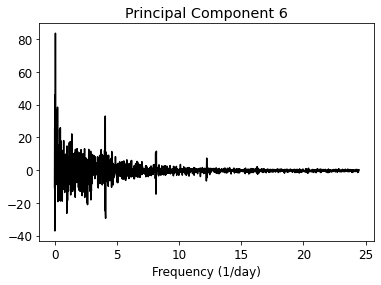

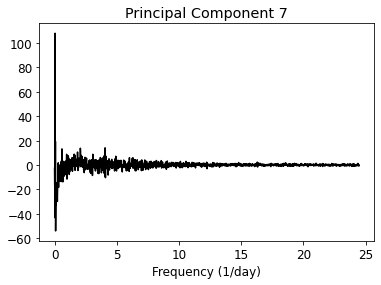

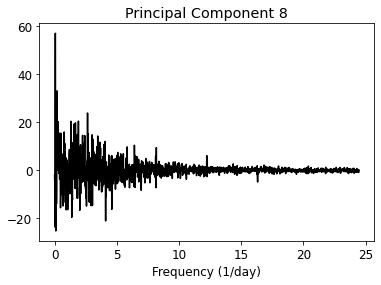

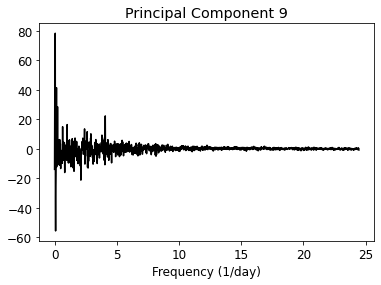

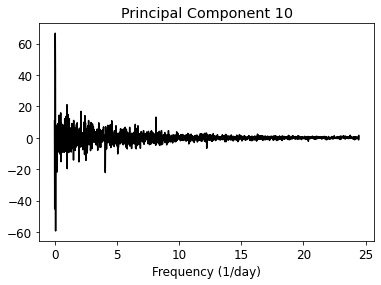

In [52]:
for i in range(0,10):
  plt.plot(frequency,pca2_df[i], 'k')
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

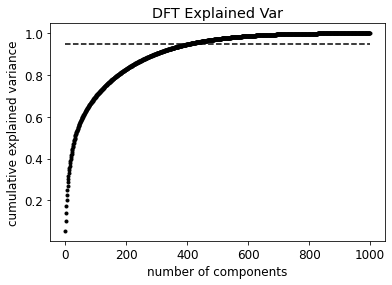

In [53]:
a = np.arange(len(y[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('DFT Explained Var')
plt.savefig('expvar2.png', bbox_inches='tight')

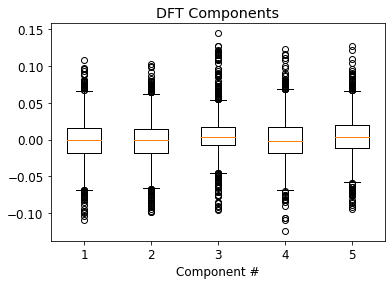

In [54]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.xlabel('Component #')
plt.title('DFT Components')
plt.savefig('box2.png', dpi=100, bbox_inches='tight')
plt.show()

## Removing 1st Component

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


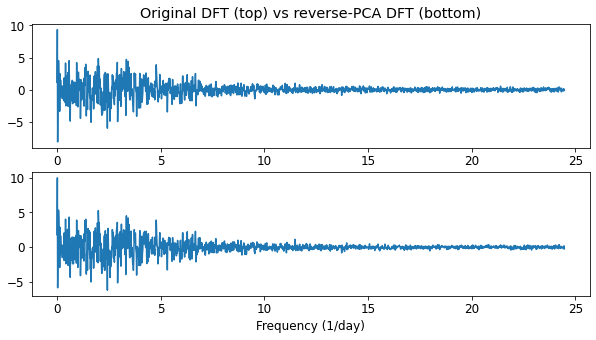

In [55]:
nComp = 400
Yhat = np.dot(pca.transform(y.real)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


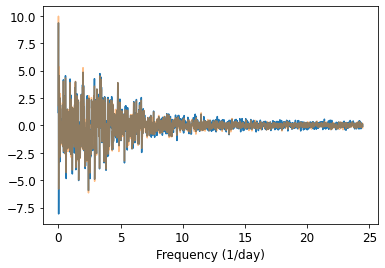

In [56]:
plt.plot(frequency,y[:,0])
plt.plot(frequency, Yhat[:,0],alpha=0.5)
plt.xlabel('Frequency (1/day)');

In [57]:
Yhatc = Yhat + (1j)*y.imag

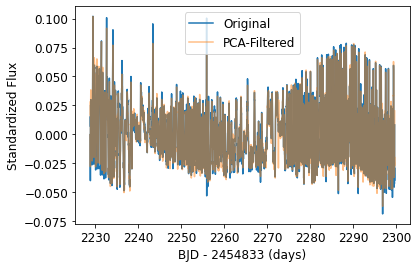

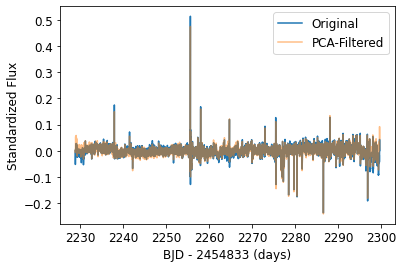

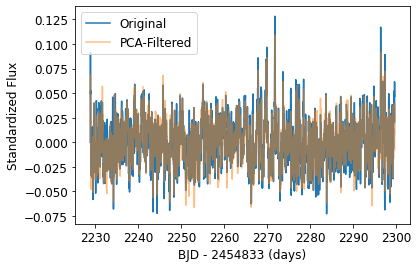

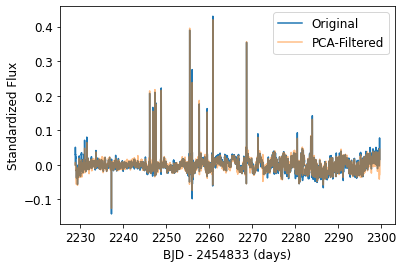

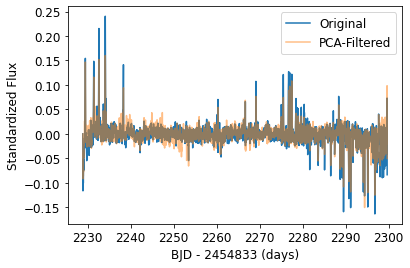

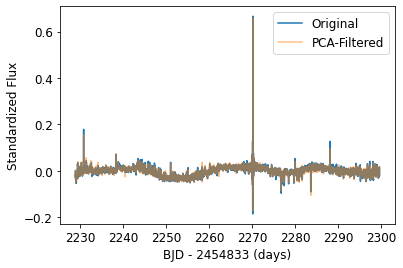

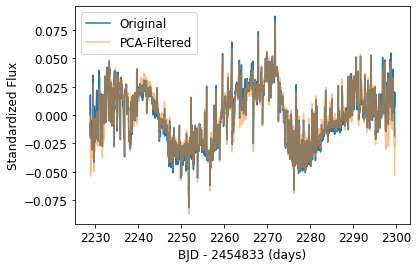

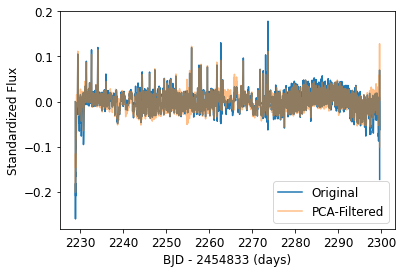

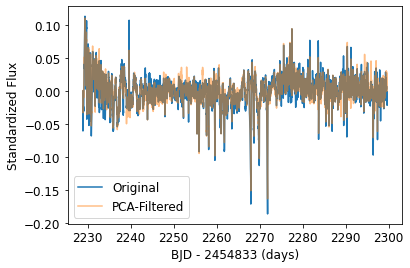

In [58]:
for i in range(0,900,100):
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()

## Bandpass Filtering 1st Component

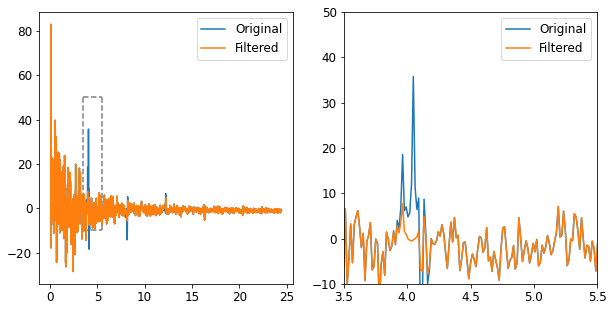

In [59]:
fstep = np.diff(frequency).mean()
fund = 4.04
nhrms = 2
std = 0.1
pts_per_std = int(std/fstep)
dftpc1 = np.copy(pca2_df[0])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc1[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc1[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc1[5:] -= local_avg
  dftpc1[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc1[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[0].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', ls='--')
ax[0].vlines(5.5,-10,50, color='grey', ls='--')
ax[0].hlines(50,3.5,5.5, color='grey', ls='--')
ax[0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[1].plot(frequency[5:], pca2_df[0][5:], label='Original')
ax[1].plot(frequency[5:], dftpc1[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

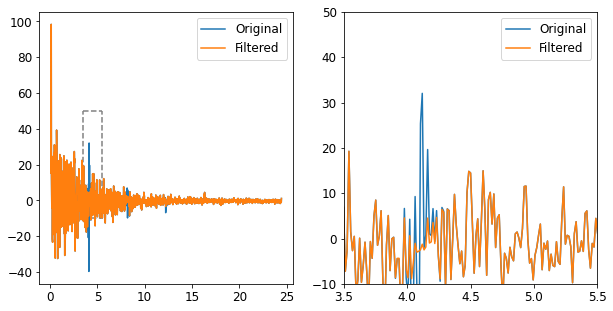

In [60]:
fstep = np.diff(frequency).mean()
fund = 4.1
nhrms = 2
std = 0.1
pts_per_std = int(std/fstep)
dftpc2 = np.copy(pca2_df[1])  

hrm_inds = []

for i in range(1,nhrms+2):
  hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


for k, ind in enumerate(hrm_inds):
  local_avg = np.mean(np.concatenate((dftpc2[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc2[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

  dftpc2[5:] -= local_avg
  dftpc2[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
  dftpc2[5:] += local_avg

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[0].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[0].vlines(3.5,-10,50, color='grey', ls='--')
ax[0].vlines(5.5,-10,50, color='grey', ls='--')
ax[0].hlines(50,3.5,5.5, color='grey', ls='--')
ax[0].hlines(-10,3.5,5.5, color='grey', ls='--')
ax[1].plot(frequency[5:], pca2_df[1][5:], label='Original')
ax[1].plot(frequency[5:], dftpc2[5:], label='Filtered')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(-10,50)
ax[0].legend()
ax[1].legend();

In [61]:
t = np.array([dftpc1, dftpc2])
filtered_transform2 = pca.transform(y.real).copy()
print(t.T.shape, filtered_transform2[:,0:2].shape)
filtered_transform2[:,0:2] = t.T

(1735, 2) (1735, 2)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


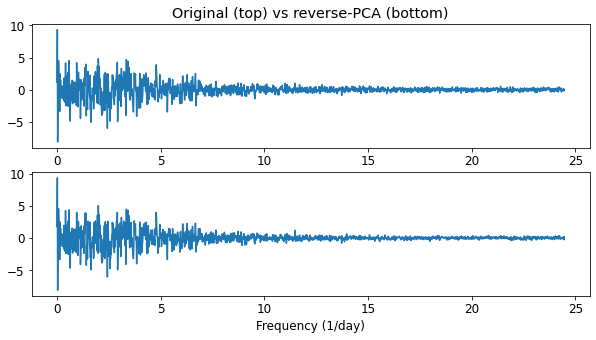

In [62]:
nComp=400

Yhat1 = np.dot(filtered_transform2[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')

In [63]:
Yhat1c = Yhat1 + (1j)*y.imag

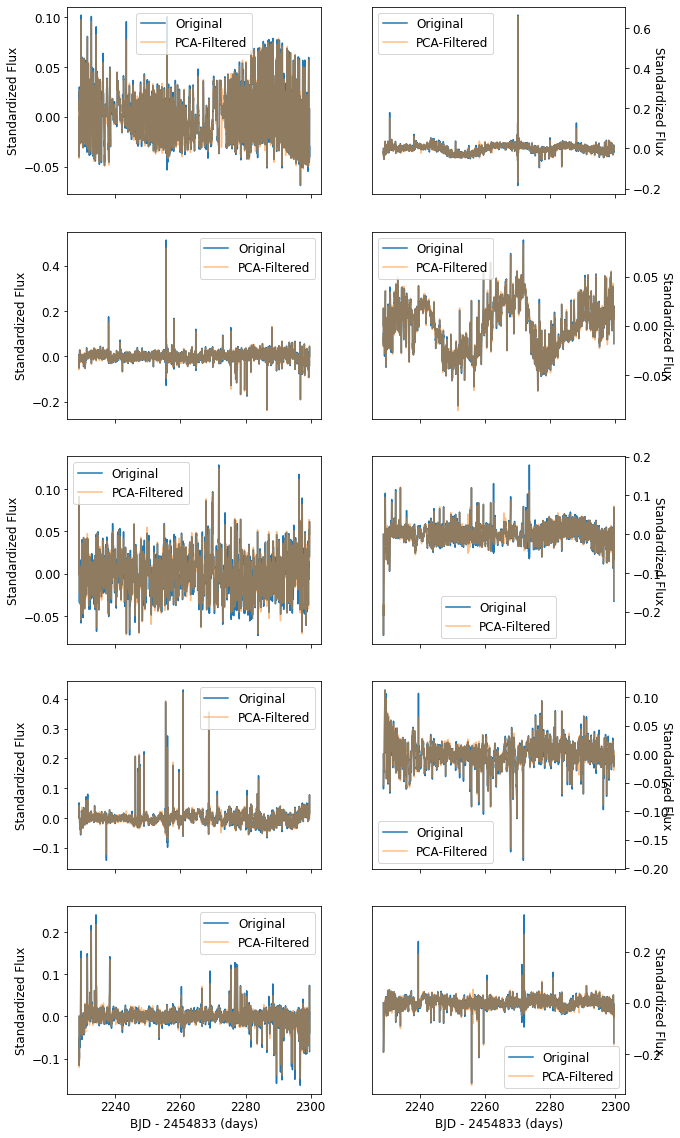

In [64]:
fig, axes = plt.subplots(5,2, figsize=(10,20), sharex=True)

axes[0,0].plot(bjds[0][1:],np.fft.irfft(y[:,0]), label='Original')
axes[0,0].plot(bjds[0][1:],np.fft.irfft(Yhat1c[:,0]), alpha=0.5, label='PCA-Filtered')
axes[0,0].set_ylabel('Standardized Flux', fontsize=12)
axes[0,0].legend(fontsize=12)

axes[1,0].plot(bjds[100][1:],np.fft.irfft(y[:,100]), label='Original')
axes[1,0].plot(bjds[100][1:],np.fft.irfft(Yhat1c[:,100]), alpha=0.5, label='PCA-Filtered')
axes[1,0].set_ylabel('Standardized Flux', fontsize=12)
axes[1,0].legend(fontsize=12)

axes[2,0].plot(bjds[200][1:],np.fft.irfft(y[:,200]), label='Original')
axes[2,0].plot(bjds[200][1:],np.fft.irfft(Yhat1c[:,200]), alpha=0.5, label='PCA-Filtered')
axes[2,0].set_ylabel('Standardized Flux', fontsize=12)
axes[2,0].legend(fontsize=12)

axes[3,0].plot(bjds[300][1:],np.fft.irfft(y[:,300]), label='Original')
axes[3,0].plot(bjds[300][1:],np.fft.irfft(Yhat1c[:,300]), alpha=0.5, label='PCA-Filtered')
axes[3,0].set_ylabel('Standardized Flux', fontsize=12)
axes[3,0].legend(fontsize=12)

axes[4,0].plot(bjds[400][1:],np.fft.irfft(y[:,400]), label='Original')
axes[4,0].plot(bjds[400][1:],np.fft.irfft(Yhat1c[:,400]), alpha=0.5, label='PCA-Filtered')
axes[4,0].set_ylabel('Standardized Flux', fontsize=12)
axes[4,0].set_xlabel('BJD - 2454833 (days)', fontsize=12)
axes[4,0].legend(fontsize=12)

axes[0,1].plot(bjds[500][1:],np.fft.irfft(y[:,500]), label='Original')
axes[0,1].plot(bjds[500][1:],np.fft.irfft(Yhat1c[:,500]), alpha=0.5, label='PCA-Filtered')
axes[0,1].yaxis.tick_right()
axes[0,1].yaxis.set_label_position("right")
axes[0,1].set_ylabel('Standardized Flux', rotation=-90, fontsize=12)
axes[0,1].legend(fontsize=12)

axes[1,1].plot(bjds[600][1:],np.fft.irfft(y[:,600]), label='Original')
axes[1,1].plot(bjds[600][1:],np.fft.irfft(Yhat1c[:,600]), alpha=0.5, label='PCA-Filtered')
axes[1,1].yaxis.tick_right()
axes[1,1].yaxis.set_label_position("right")
axes[1,1].set_ylabel('Standardized Flux', rotation=-90, fontsize=12)
axes[1,1].legend(fontsize=12)

axes[2,1].plot(bjds[700][1:],np.fft.irfft(y[:,700]), label='Original')
axes[2,1].plot(bjds[700][1:],np.fft.irfft(Yhat1c[:,700]), alpha=0.5, label='PCA-Filtered')
axes[2,1].yaxis.tick_right()
axes[2,1].yaxis.set_label_position("right")
axes[2,1].set_ylabel('Standardized Flux', rotation=-90, fontsize=12)
axes[2,1].legend(fontsize=12)

axes[3,1].plot(bjds[800][1:],np.fft.irfft(y[:,800]), label='Original')
axes[3,1].plot(bjds[800][1:],np.fft.irfft(Yhat1c[:,800]), alpha=0.5, label='PCA-Filtered')
axes[3,1].yaxis.tick_right()
axes[3,1].yaxis.set_label_position("right")
axes[3,1].set_ylabel('Standardized Flux', rotation=-90, fontsize=12)
axes[3,1].legend(fontsize=12)

axes[4,1].plot(bjds[900][1:],np.fft.irfft(y[:,900]), label='Original')
axes[4,1].plot(bjds[900][1:],np.fft.irfft(Yhat1c[:,900]), alpha=0.5, label='PCA-Filtered')
axes[4,1].yaxis.tick_right()
axes[4,1].yaxis.set_label_position("right")
axes[4,1].set_ylabel('Standardized Flux', rotation=-90, fontsize=12)
axes[4,1].set_xlabel('BJD - 2454833 (days)', fontsize=12)
axes[4,1].legend(fontsize=12)

plt.savefig('lc_detrend.png', dpi=100, bbox_inches='tight')

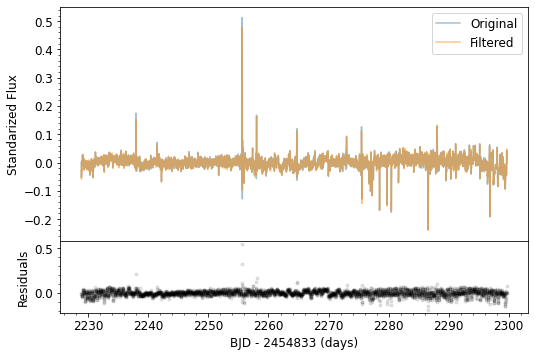

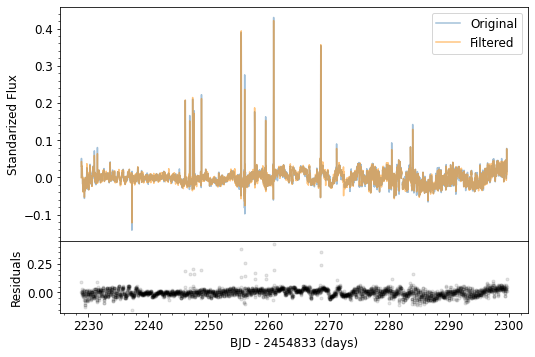

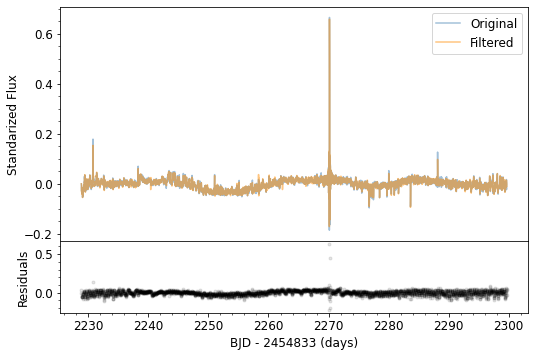

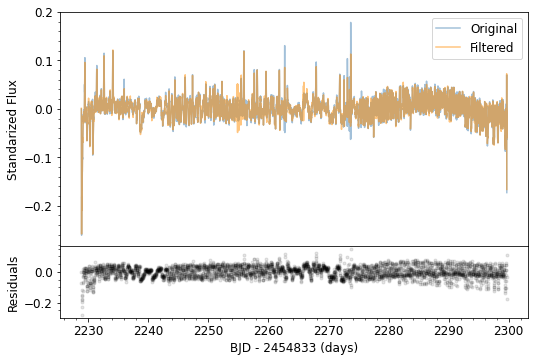

In [65]:
for i in range(100,900,200):

  fig = plt.figure(figsize=(10,5))

  res = np.fft.irfft(y[:,i]) - np.fft.irfft(Yhat1c[:,0])

  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65
  #bottom_h = left_h = left + width

  rect_scatter = [left, bottom + 0.2, width, height]
  rect_histx = [left, bottom, width, 0.2]
  #    rect_histy = [left_h, bottom, 0.2, height]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter)
  axres = plt.axes(rect_histx)
  ax1.minorticks_on()
  axres.minorticks_on()
  plt.setp(ax1.get_xticklabels(),
            visible=False)

  ax1.plot(bjds[i][1:], np.fft.irfft(y[:,i]), color='SteelBlue', alpha=0.5,
                                  label='Original')
  ax1.plot(bjds[i][1:], np.fft.irfft(Yhat1c[:,i]),
                                 color='DarkOrange', alpha=0.5,
                                  label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres.errorbar(bjds[i][1:], res, yerr=None, color='k',
                               alpha=0.1, fmt='.')
  axres.set_xlabel('BJD - 2454833 (days)')
  axres.set_ylabel('Residuals')
  plt.show()

# Investigating TOIs

## Check periodicity

In [66]:
!pip install PyAstronomy

     |████████████████████████████████| 686kB 5.5MB/s 
  Created wheel for PyAstronomy: filename=PyAstronomy-0.15.2-cp36-none-any.whl size=485642 sha256=b082ea86609ee2bc1211f38e21ba8bf19f6f32ec8431ccea24e75397925483ce
  Stored in directory: /root/.cache/pip/wheels/b1/13/e7/8e4c922b6281920bb4bd0b5a36407c06108634c0f88c2330f8
Successfully built PyAstronomy


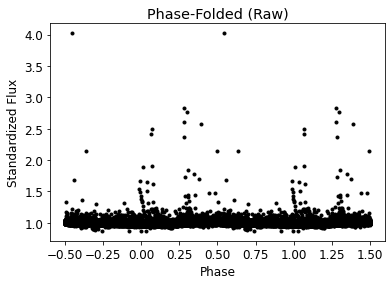

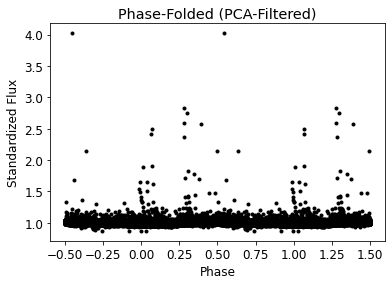

In [67]:
from PyAstronomy.pyasl import foldAt

period = 0.2185
dur = np.nanmax(time1) - np.nanmin(time1)

# Obtain the phases with respect to some
# reference point 
phases = foldAt(time1[1:], period, T0=np.nanmin(time1))

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
# Plot the result


plt.plot(phases-0.5, flux1norm[sortIndi], 'k.')
plt.plot(phases+0.5, flux1norm[sortIndi], 'k.')
#plt.plot(p-0.5, quadfit, c='cyan')
#plt.plot(p+0.5, quadfit, c='cyan')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (Raw)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
plt.savefig('phasefold1.png',dpi=100,bbox_inches='tight')
plt.show()

plt.plot(phases-0.5, Filtered_signal1[sortIndi], 'k.')
plt.plot(phases+0.5, Filtered_signal1[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (PCA-Filtered)')
#plt.xlim(-0.5,1.5)
#plt.ylim(-0.1,0.1)
plt.savefig('phasefold2.png',dpi=100,bbox_inches='tight')
plt.show()

## Model flares

In [68]:
flares = [2253.65107,
          2240.04075,
          2281.57290,
          2284.68258,
          2287.91009,
          2268.87127,
          2295.39965,
          2299.37770,
          2291.45770,
          2248.59421,
          2261.51045,
          2269.02792,
          2249.17243,
          2276.02709,
          2229.08574,
          2293.30131,
          2295.02575,
          2258.54786,
          2284.92844,
          2238.85706,
          2251.42265,
          2249.41148,
         ]

In [69]:
len(flares)

22

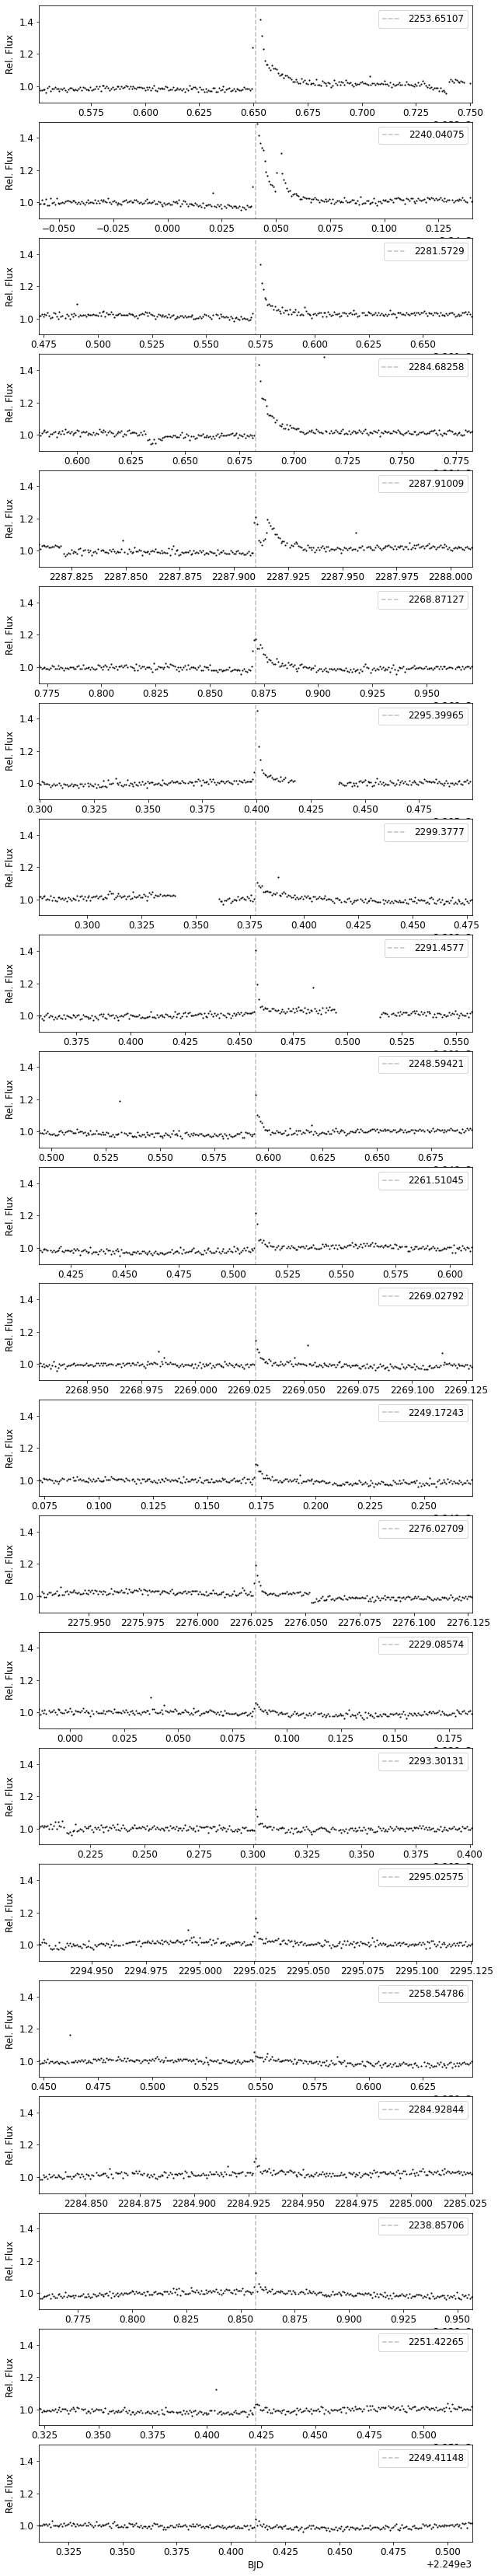

In [70]:
fig, axes = plt.subplots(22, figsize=(10,60))

for i,flare in enumerate(flares):
  axes[i].scatter(time1, Filtered_signal1, color='k', marker='.', s=5)
  axes[i].vlines(flare, -50, 50, color='k', ls='--', alpha=0.25, label=str(flare))
  #axes[i].vlines(flare+(1./72), -50, 50, color='k', ls='--', alpha=0.75)
  #axes[i].vlines(flare-(1./96), -50, 50, color='k', ls='--', alpha=0.75)
  axes[i].set_xlim(flare-0.1,flare+0.1)
  axes[i].set_ylim(0.9,1.5)
  axes[i].set_ylabel('Rel. Flux')
  axes[i].legend()
plt.xlabel('BJD', fontsize=12)
plt.savefig('flares.png', bbox_inches='tight')
plt.show()

## Gabor Filtering

In [71]:
from skimage.filters import gabor

In [72]:
def gabor1D(x, Lambda, theta=0, bandwidth=1, sigma=None,
                 nstds=3, offset=0):

  gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * np.cos(2 * np.pi / Lambda * x + offset)

  return gb

Lambda = 1


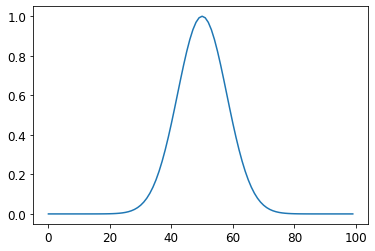

Lambda = 2


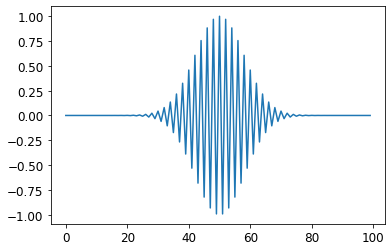

Lambda = 4


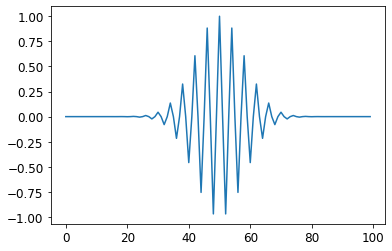

Lambda = 8


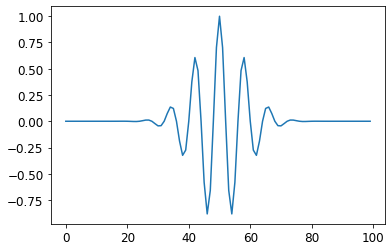

Lambda = 16


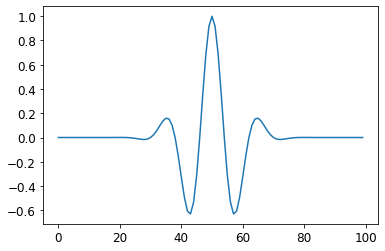

Lambda = 32


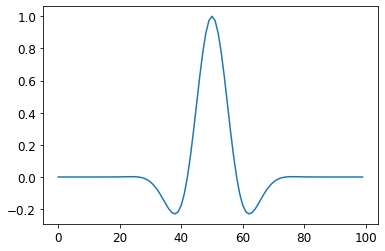

In [73]:
i=1
x = np.arange(-50,50)
while i <= 32:
  print('Lambda = {}'.format(i))
  plt.plot(gabor1D(x, Lambda=i, sigma=8, nstds=10))
  plt.show()
  i *= 2

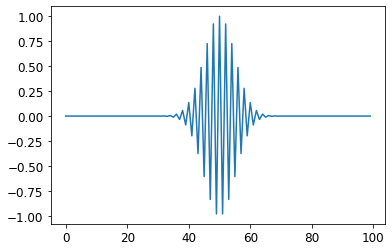

In [74]:
plt.plot(gabor1D(x, 2, sigma=5, nstds=5))
plt.savefig('gabor.png', dpi=100)

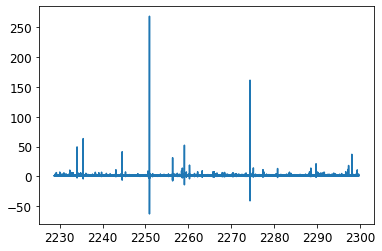

In [75]:
plt.plot(time2[1:], Filtered_signal2)

In [76]:
peakind = np.where(Filtered_signal2==Filtered_signal2.max())[0][0]

In [77]:
conv = np.convolve(Filtered_signal2, gabor1D(x, Lambda=2,sigma=5,nstds=5))

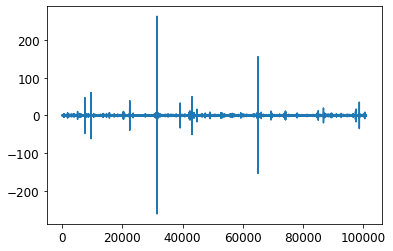

In [78]:
plt.plot(conv)

In [79]:
np.where(conv == conv.max())

(array([31540]),)

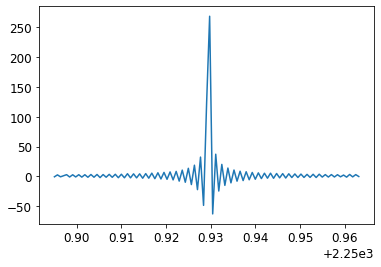

In [80]:
plt.plot(time2[1:][peakind-50:peakind+50], Filtered_signal2[peakind-50:peakind+50])

In [81]:
@interact
def gfiltergame(l=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=2),
                s=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=5),
                a=widgets.FloatSlider(min=1, max=50, step=1, value=30),
                offset1 = widgets.IntSlider(min=0, max=10, step=1, value=0),
                offset2 = widgets.IntSlider(min=0, max=10, step=1, value=1)):
  
  n=10
  y = Filtered_signal2[peakind-50:peakind+50]
  x = np.arange(-len(y)/2,len(y)/2)

  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)

  gabor = np.concatenate((gabor1[offset1:int(len(y)/2)], np.zeros(offset1), np.zeros(offset2), gabor2[int(len(y)/2):len(y)-offset2]))

  '''
  plt.plot(x, gabor1[offset1:int(len(y)/2)], label='Gabor1')
  plt.plot(x, gabor2[int(len(y)/2):-offset2], label='Gabor2')
  plt.plot(x, y, alpha=0.5, label='Ringing')
  plt.vlines(0,-200,200, alpha=0.5, ls='--')
  plt.legend()
  plt.show()
  '''
  plt.plot(x,y, label='Data')
  plt.legend()
  plt.show()

  plt.plot(x,y - gabor, color='r', label='Result')
  plt.vlines(0,-200,200, alpha=0.5, ls='--')
  plt.ylim(-50,300)
  plt.legend();

interactive(children=(FloatSlider(value=2.0, description='l', max=10.0, min=0.1), FloatSlider(value=5.0, descr…

In [82]:
a = 30
s = 5
l = 2
offset1_true = 0 
offset2_true = 1 
n=10

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

def gmodel(x,a,s,l):

  n=10

  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor = np.concatenate((gabor1[offset1_true:int(len(y)/2)], np.zeros(offset1_true), 
                          np.zeros(offset2_true), gabor2[int(len(y)/2):len(y)-offset2_true]))

  return gabor



In [83]:
yred = y - gmodel(x,a,s,l)
np.where(yred == yred.max())[0][0]

50

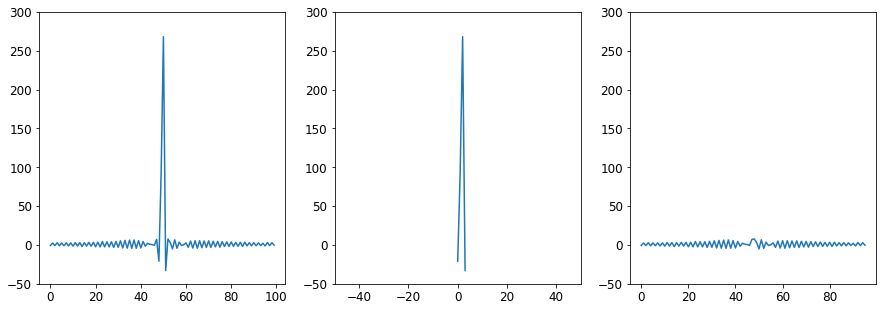

In [84]:
flrmask = np.ones_like(yred, dtype='bool')
flrmask[48:52] = False

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(yred)
ax[1].plot(yred[~flrmask])
ax[2].plot(yred[flrmask])

ax[0].set_ylim(-50,300)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,300)
ax[2].set_ylim(-50,300);

## Gabor Optimization

In [85]:
!pip install emcee

     |████████████████████████████████| 51kB 2.6MB/s 


In [86]:
!pip install corner

In [87]:
import emcee
from scipy.optimize import minimize

In [88]:
offset_fctr = 1e-4

a_true = 30
s_true = 5
l_true = 2
m_true = np.mean(y[:30])
offset1_true = 0 * offset_fctr
offset2_true = 1 * offset_fctr

n=10

def gmodel(x,a,s,l,offset1,offset2):

  n=10
  #print(int(offset1 / offset_fctr), int(offset2 / offset_fctr))
  gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
  gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y)/2)], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)]))
  return gabor

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

def log_likelihood(theta, x, y):
    if len(theta) == 4:
      a,s,l,m = theta
      offset1 = offset1_true
      offset2 = offset2_true
    if len(theta) == 6:
      a, s, l, m, offset1, offset2 = theta

    model = gmodel(x,a,s,l,offset1,offset2)
    yred = y - model
    pred = np.zeros_like(yred)[flrmask] + m # put NaNs in here @ flare
    return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)

In [89]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a_true, s_true, l_true, m_true]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x, y))
a_ml, s_ml, l_ml, m_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("s = {0:.3f}".format(s_ml))
print("l = {0:.3f}".format(l_ml))
print("m = {0:.3f}".format(m_ml))

Maximum likelihood estimates:
a = 24.085
s = 7.208
l = 2.000
m = 1.011


In [90]:
def log_prior(theta):
    a, s, l, m, offset1, offset2 = theta
    if 0.0 < a < 50.0 and 0.0 < s < 10.0 and 0.0 < l < 20.0 and 0.0 < m < 5.0 \
    and int(0) < offset1 < (10 * offset_fctr) and int(0) < offset2 < (10 * offset_fctr):
        return 0.0
    return -np.inf

In [91]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [92]:
soln6 = np.append(soln.x, [offset1_true, offset2_true])

In [122]:
###MCMC
pos = soln6 + 1e-3 * np.random.randn(128, 6)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:41<00:00, 120.06it/s]


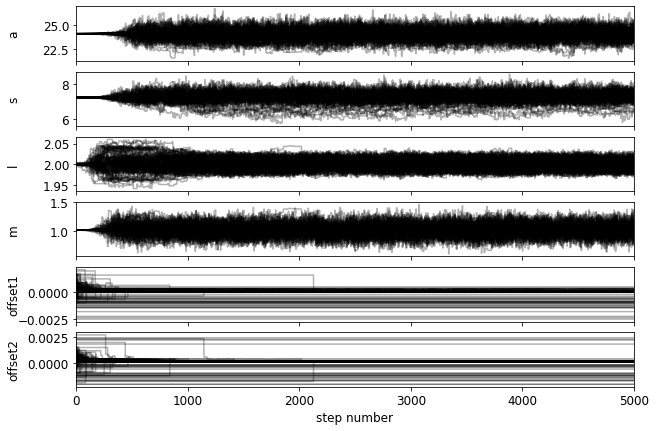

In [123]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "s", "l", "m", "offset1", "offset2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [139]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(41728, 6)


In [140]:
flat_samples[:,4:] /= offset_fctr

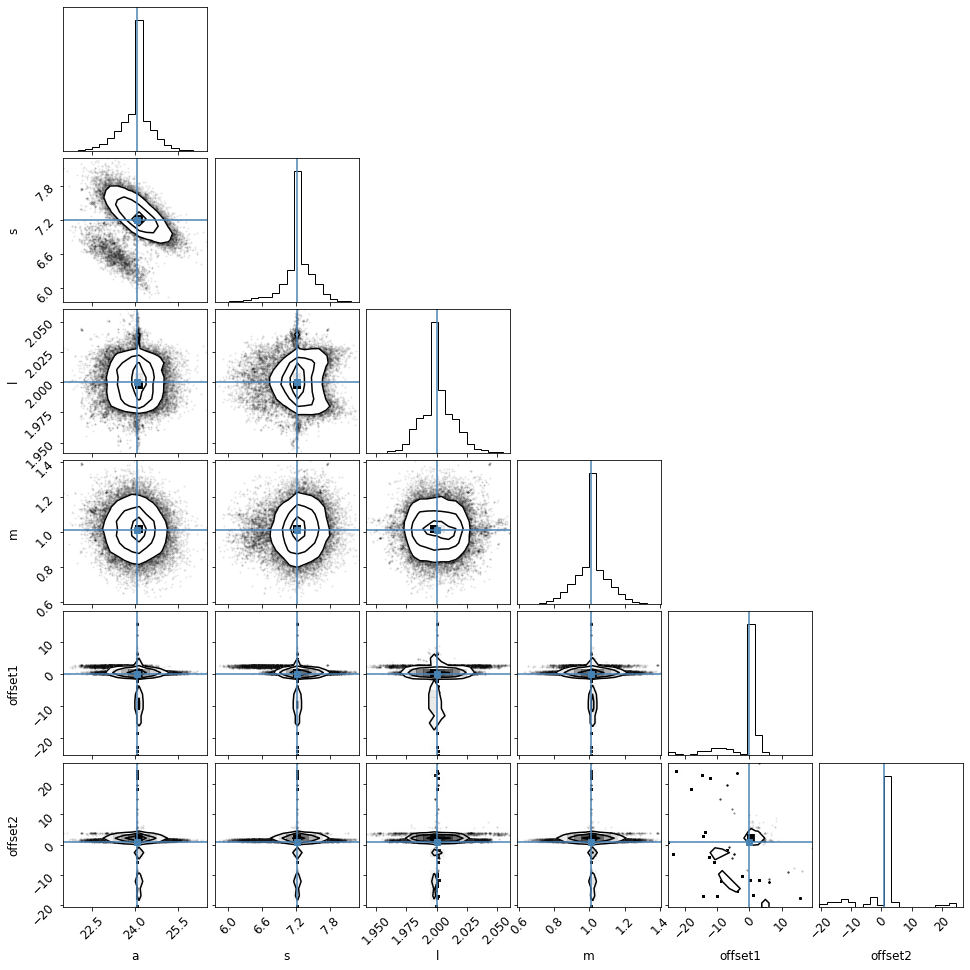

In [141]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[a_ml, s_ml, l_ml, m_ml, offset1_true / offset_fctr, offset2_true / offset_fctr]
)

axes = np.array(fig.axes).reshape((ndim, ndim))

plt.savefig('gabor_corner.png', dpi=100, bbox_inches='tight')

In [142]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    if "offset" in labels[i]:
      txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    else:
      txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

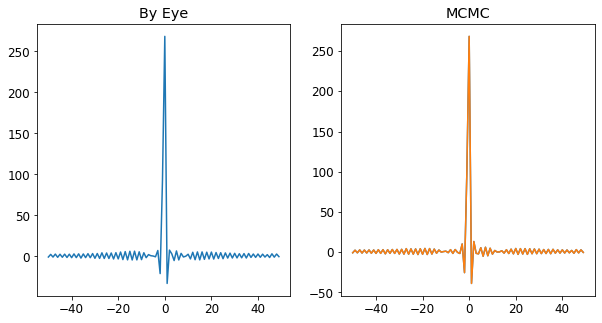

In [131]:
a_fit = np.percentile(flat_samples[:, 0], 50)
s_fit = np.percentile(flat_samples[:, 1], 50)
l_fit = np.percentile(flat_samples[:, 2], 50)
m_fit = np.percentile(flat_samples[:, 3], 50)
off1_fit = np.percentile(flat_samples[:, 4], 50)
off2_fit = np.percentile(flat_samples[:, 5], 50)

y = Filtered_signal2[peakind-50:peakind+50]
x = np.arange(-len(y)/2,len(y)/2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, yred)
ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, offset1_true, offset2_true))
ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr))

ax[0].set_title('By Eye')
ax[1].set_title('MCMC')
plt.savefig('mcmc_comp.png', dpi=100, bbox_inches='tight')

### Automating MCMC

In [98]:
def auto_MCMC(flare, offset_factor, n, true_params):
  
  a_true, s_true, l_true, m_true, offset1_true, offset2_true = true_params

   y = flare
    x = np.arange(-len(y)/2,len(y)/2)

  def gmodel(x,a,s,l,offset1,offset2):

    gabor1 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
    gabor2 = -a*gabor1D(x, Lambda = l, sigma=s, nstds=n)
    gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y)/2)], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)]))
    return gabor


  def log_likelihood(theta, x, y):
    if len(theta) == 4:
      a,s,l,m = theta
      offset1 = offset1_true
      offset2 = offset2_true
    if len(theta) == 6:
      a, s, l, m, offset1, offset2 = theta

    model = gmodel(x,a,s,l,offset1,offset2)
    yred = y - model
    pred = np.zeros_like(yred)[flrmask] + m # put NaNs in here @ flare
    return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)